# Imports

In [30]:
import pandas as pd
import joblib
import numpy as np
import datetime
import seaborn as sns
from helper_metrics import count_missing_district, count_missing_district_total, make_confusion_matrix, calculate_results
import matplotlib.pyplot as plt
from sklearn.experimental    import enable_iterative_imputer
from sklearn.impute          import IterativeImputer
from sklearn.experimental    import enable_hist_gradient_boosting
from sklearn.ensemble        import HistGradientBoostingRegressor

from sklearn.model_selection import KFold
from sklearn.metrics         import mean_absolute_error, accuracy_score
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

# Load data

In [31]:
df = pd.read_csv("data/semiyearly_chosen_columns.csv").iloc[:,1:]
df

,date,district,total population,Under-Five Population,GAM,MAM,SAM,GAM Prevalence,SAM Prevalence,phase3plus_perc_x,...,Total alarms,n_conflict_total,Average of centy,Average of centx,prevalence_6lag,next_prevalence,month,increase,increase_numeric,district_encoded
0,2017-07-01,Adan Yabaal,65262.96000,13052.59200,4819.01697,3733.04131,1085.97565,0.36920,0.08320,0.18000,...,2.16667,NaN,3.54944,46.54467,NaN,0.35100,7,False,-0.01820,0
1,2017-07-01,Lughaye,70268.22000,14053.64400,5334.76326,4220.30929,1114.45397,0.37960,0.07930,0.36000,...,2.66667,1.00000,10.64738,43.57812,NaN,0.16900,7,False,-0.21060,58
2,2017-07-01,Buuhoodle,71317.71000,14263.54200,4858.16241,3652.89311,1205.26930,0.34060,0.08450,0.37000,...,2.33333,2.50000,8.46016,46.66129,NaN,0.20280,7,False,-0.13780,23
3,2017-07-01,Luuq,100476.76500,20095.35300,8673.15435,7366.95641,1306.19795,0.43160,0.06500,0.21000,...,7.83333,1.50000,3.79293,42.69760,NaN,0.39260,7,False,-0.03900,59
4,2017-07-01,Burtinle,112734.27000,22546.85400,10200.19675,8500.16396,1700.03279,0.45240,0.07540,0.22000,...,3.66667,NaN,7.80220,48.39912,NaN,0.37960,7,False,-0.07280,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,2021-07-01,Jariiban,NaN,32671.60000,10890.00000,NaN,1430.00000,0.33332,0.04377,0.19000,...,2.16667,NaN,7.16378,48.99860,0.34857,NaN,7,NaN,NaN,50
658,2021-07-01,Caluula,NaN,16168.60000,5560.00000,NaN,870.00000,0.34388,0.05381,0.16000,...,3.16667,1.00000,11.66822,50.79402,0.35925,NaN,7,NaN,NaN,28
659,2021-07-01,Qoryooley,NaN,25309.00087,11420.00000,NaN,2160.00000,0.45122,0.08535,0.08000,...,6.16667,3.50000,1.93456,44.44943,0.45939,NaN,7,NaN,NaN,65
660,2021-07-01,Baki,NaN,11187.80000,3470.00000,NaN,640.00000,0.31016,0.05721,0.37000,...,0.66667,1.00000,10.28566,43.73210,0.22769,NaN,7,NaN,NaN,7


# Create train and test sets
X does not need to drop nan values as HGBR can handle nan inputs

In [32]:
y = df.next_prevalence.dropna()
X = df.select_dtypes(exclude=["object", "category"]).iloc[:len(y)].drop("next_prevalence", axis=1)

# Subsets

In [33]:
# Function that returns every possible subset (except the empty set) of the input list l
def subsets(l: object) -> object:
    subset_list = []
    for i in range(len(l) + 1):
        for j in range(i):
            subset_list.append(l[j: i])
    return subset_list

# Cross Validation Training

In [34]:
73*5

365

In [35]:
'''------------SECTION FINAL EVALUATION--------------'''
best_model_columns = ['total population', 'Under-Five Population', 'GAM', 'MAM', 'SAM', 'GAM Prevalence', 'SAM Prevalence', 'phase3plus_perc_x', 'rainfall', 'ndvi_score', 'Price of water', 'Total alarms', 'n_conflict_total', 'Average of centy', 'Average of centx', 'prevalence_6lag', 'month', 'increase_numeric']
y = df['next_prevalence'].values
X = df[best_model_columns].values

# If there is only one explanatory variable, the values need to be reshaped for the model
if len(best_model_columns) == 1:
    X = X.reshape(-1, 1)

# Peform evaluation on full data
Xtrain = X[:365]
ytrain = y[:365]
Xtest = X[365:]
ytest = y[365:]

clf = joblib.load("hgbr.joblib")
predictions = clf.predict(Xtest)

In [36]:
# Calculate MAE
y_true = pd.Series(ytest[:-73]).drop(69)
y_pred = pd.Series(predictions[:-73]).drop(69)
#MAE = mean_absolute_error(ytest, predictions)
MAE = mean_absolute_error(y_true, y_pred)

# Generate boolean values for increase or decrease in prevalence. 0 if next prevalence is smaller than current prevalence, 1 otherwise.
increase = np.where(df.iloc[365:]["next_prevalence"] < df.iloc[365:]["GAM Prevalence"],0,1)
predicted_increase = np.where(predictions < df.iloc[365:]["GAM Prevalence"],0,1)

len(increase), len(predicted_increase)

(297, 297)

In [42]:
# Calculate accuracy of predicted boolean increase/decrease
acc = accuracy_score(increase, predicted_increase)

# Print model scores
print(f"MAE: {np.round(MAE,4)}, Accuracy: {np.round(acc,3)*100}%")

MAE: 0.0218, Accuracy: 74.4%


# Metrics

In [38]:
calculate_results(y_true=increase, y_pred=predicted_increase)

{'accuracy': 74.41077441077442,
 'precision': 0.7837669625548414,
 'recall': 0.7441077441077442,
 'f1': 0.7458458582493112}

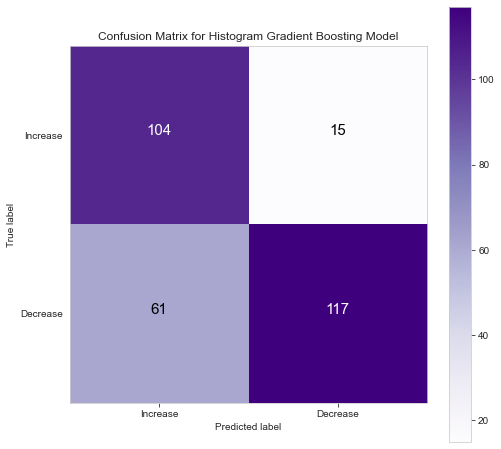

In [45]:
make_confusion_matrix(y_true=increase, y_pred=predicted_increase,classes=["Increase", "Decrease"],title="Confusion Matrix for Histogram Gradient Boosting Model", cmap=plt.cm.Purples, figsize=(8,8))